## Automating Regional Briefings
Author: Smitha Mahesh, Eric Englin

Purpose: To complete the analyses and visualizations required for the region-level briefings. 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import docx

In [2]:
myworkingdirectory = r"C:\Users\Sophie.Kaye\DOT OST\volpe-proj-VU16A100 - Transportation Safety Program\Region Briefing"
os.chdir(myworkingdirectory)

In [3]:
analysis_2022 = pd.read_csv(".//Data//Output Data//analysis_database_2022.csv")


In [4]:
park_info = pd.read_csv(".//Data//Reference Data/Park_Info_Table.csv")
park_info = park_info.rename(columns={'UNIT_CODE':'Park','REGION':'RGN'})


In [5]:
analysis_2022.columns

Index(['INCID_NO', 'NUM_OCC', '5_mph', '10_mph', '15_mph', '20_mph', '25_mph',
       '30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph',
       '65_mph', '70_mph', '75_mph', 'no_posted_speed', 'Crosswalk',
       'Outside a Crosswalk', 'No Injury', 'Possible Injury',
       'Non-incapacitating Injury', 'Incapacitating Injury', 'Fatality',
       'Unknown Injury', 'Num_Fatalities', 'Num_Injuries', 'Injury or Fatal',
       'Pedestrian', 'Bicycle', 'Pedacycle', 'VRU', 'HorseLlama', 'Cow',
       'Deer', 'Elk', 'Moose', 'Buffalo', 'Bear', 'Antelope', 'SheepGoats',
       'OtherWild', 'OtherDomestic', 'Involving Animal', 'LATITUDE',
       'LONGITUDE', 'Park', 'RGN', 'CRASH_DATE', 'CRASH_TIME', 'CRASH_YEAR',
       'database'],
      dtype='object')

## Available Data Fields

In [6]:
analysis_2022.database.value_counts()

CDS      194307
IMARS     11804
Name: database, dtype: int64

In [7]:
safety_studies = pd.read_excel(".//Safety Studies//NPS_TSP_Safety_Study_Catalog_2010-2020.xlsx",  "Safety Studies 2010-2020 ")
safety_studies['RGN'] = safety_studies['Legacy Region Abbreviation']
safety_studies['INCID_NO']=1

In [8]:
safety_analyst_parks = pd.read_excel(".//Data//Safety Analyst//Safety Analyst Parks.xlsx")
safety_analyst_parks['Safety Analyst Park']=1

In [9]:
analysis_2022_merge = analysis_2022.merge(safety_analyst_parks, on="Park", how = "left")

In [10]:
analysis_2022_merge.shape, analysis_2022.shape

((206111, 55), (206111, 53))

In [11]:
def pull_source_table_data(df, region, field, filter_value):
    df = df.loc[df['RGN']==region]
    df = df.loc[df[field]==filter_value]
    parks, crashes = df.groupby("Park").agg({
        'INCID_NO':'count',
    }).reset_index().agg({
        "Park":"count",
        'INCID_NO':sum,
    })
    
    parks = str(parks) + " Park Units"
    crashes = "{:,}".format(crashes) + " Crash Reports"
    
    return parks, crashes


def make_source_table(region):

    CDS_parks, CDS_crash_reports = pull_source_table_data(analysis_2022_merge, region, 'database', 'CDS')
    IMARS_parks, IMARS_crash_reports = pull_source_table_data(analysis_2022_merge, region, 'database', 'IMARS')
    SA_parks, SA_crash_reports = pull_source_table_data(analysis_2022_merge, region, 'Safety Analyst Park', 1)
    SS_parks, SS_crash_reports = pull_source_table_data(safety_studies, region, 'INCID_NO', 1)

    source_list = []
    parks_list = [CDS_parks, IMARS_parks, SA_parks, SS_parks]
    crash_reports_list = [CDS_crash_reports, IMARS_crash_reports, SA_crash_reports, SS_crash_reports]

    final_df = pd.DataFrame({
        "Source":["Crash Data System (CDS)", 
                  "Incident Management Analysis and Reporting System (IMARS)",
                  'Safety Analyst', "Safety Studies"],
        "Locations": parks_list,
        'Years': ["1989-2013", "2012-present", "2005-2014", "2010-present"],
        "Quantity of Data": crash_reports_list
    })
    
    return final_df


## Data Quality Tables

### CDS

In [12]:
cds_crash = pd.read_excel('./Data/New CDS/New CDS Excel Files/ALL_CRASH.xlsx')
cds_crash = cds_crash.rename(columns={'PARK_ALPHA' : 'Park'})

In [13]:
# add RGN column from lookup table to CDS crash database, joining the two datasets based on park name
cds_crash = pd.merge(cds_crash, park_info[['RGN','Park']], how='left', on='Park')
# resulting dataframe after join should have one additional column and no additional rows
cds_crash = cds_crash.drop_duplicates() 
cds_crash.shape

(204687, 57)

In [14]:
cds_crash.columns

Index(['OBJECTID', 'INCID_NO', 'CASE_NUM', 'Park', 'STATE_CODE', 'CRASH_DATE',
       'CRASH_TIME', 'RTE_NO', 'RTE_NAME', 'NODE_DIST_FT', 'NODE_DIST_MI',
       'NODE_DIR', 'NODE_NUM', 'LIGHT', 'WEATHER', 'CRASH_LOCATION',
       'SURF_COND', 'CRASH_CLASS', 'VEH_COLL', 'OBJ_STRUCK', 'ROAD_CHAR',
       'CON_FACT1', 'CON_FACT2', 'CON_FACT3', 'CON_FACT4', 'CON_FACT5',
       'CON_FACT6', 'HIT_RUN', 'CATEGORY', 'FATALS', 'INJURED', 'PED_FAT',
       'PED_INJ', 'BIKE_FAT', 'BIKE_INJ', 'PED', 'CRASH_YEAR', 'COMMENTS',
       'ZIPFILE', 'LOCATION', 'PHOTOS_TAKEN', 'USPP_NPS_VEH_INV',
       'PARK_PTY_DEST', 'LOCKED_UPDATE', 'LOCKED_BY_USER', 'DATA_SRC',
       'LATITUDE', 'LONGITUDE', 'MILEPOST', 'IMPORT_DATE', 'FILE_NAME',
       'SAVE_DATE', 'ROUTE_IDENT', 'RIP_CYCLE', 'MP_NODE', 'SPTL_LOC', 'RGN'],
      dtype='object')

In [15]:
cds_unit = pd.read_excel('./Data/New CDS/New CDS Excel Files/ALL_UNIT.xlsx')

In [16]:
cds_unit.columns

Index(['OBJECTID', 'INCID_NO', 'UNIT_NO', 'VEH_YEAR', 'MAKE_MOD', 'MODEL',
       'NUM_OCC', 'REG_STATE', 'REG_YEAR', 'PLATE_NUM', 'DIR_TRAVEL',
       'SPEED_LIMIT', 'BODY_TYPE', 'VEH_MANVR', 'VEH_DAMAGE', 'DAM_LOCATION',
       'LIC_NUM', 'LIC_STATE', 'PED', 'BRTH_DATE', 'DRIVER_SEX', 'DRIVER_BELT',
       'DRIVER_EJECT', 'DRIVER_INJ', 'DRIVER_VIOLTN', 'VIOL_CHG1', 'VIOL_CHG2',
       'PED_TYPE', 'PED_LOC', 'PED_ACTN', 'REPAIR'],
      dtype='object')

In [17]:
cds_unit = cds_unit.merge(cds_crash[['INCID_NO','Park','RGN']], on = 'INCID_NO', how = 'left')


In [18]:
#cds_df_crash to find lat/long
#cds_df_unit to find speed

In [19]:
def make_data_quality_table_cds(region):
    not_linked_table = pd.DataFrame({
        "Area":["National", "NCR", "IMR",'SER','PWR','NER','MWR','AKR'],
        'Total': [203909, 97838, 33076,27262, 24419,18642, 2435, 237], 
        "Unlinked": [9602, 7988, 183, 1221, 117, 73,19, 1]
    })
    not_linked_table["Unlinked Percent"]=round(not_linked_table["Unlinked"]/not_linked_table['Total']*100,2)
    
    df = not_linked_table.loc[(not_linked_table['Area']=="National")|(not_linked_table['Area']==region)]
    
    cds_crash_region = cds_crash.loc[cds_crash['RGN']==region[:2]]
    
    df['Missing coordinates'] = (len(cds_crash.loc[cds_crash['LATITUDE'].isnull()==True]),
                                len(cds_crash_region.loc[cds_crash_region['LATITUDE'].isnull()==True]))
    
    cds_unit_region = cds_unit.loc[cds_unit['RGN']==region[:2]]
    df['Missing speed'] = (len(cds_unit.loc[(cds_unit['SPEED_LIMIT'].isnull()==True)|(cds_unit['SPEED_LIMIT']==99)]),
                                len(cds_unit_region.loc[(cds_unit_region['SPEED_LIMIT'].isnull()==True)|(cds_unit_region['SPEED_LIMIT']==99)]))
    
    no_ConFact1 = cds_crash.loc[cds_crash['CON_FACT1'].isnull()==True]
    no_ConFact1_2 = no_ConFact1.loc[no_ConFact1['CON_FACT2'].isnull()==True]
    no_ConFact1_3 = no_ConFact1_2.loc[no_ConFact1_2['CON_FACT3'].isnull()==True]
    no_ConFact1_4 = no_ConFact1_3.loc[no_ConFact1_3['CON_FACT4'].isnull()==True]
    no_ConFact1_5 = no_ConFact1_4.loc[no_ConFact1_4['CON_FACT5'].isnull()==True]
    no_ConFact_any = no_ConFact1_5.loc[no_ConFact1_5['CON_FACT6'].isnull()==True]
    
    no_ConFact_any_region = no_ConFact_any.loc[no_ConFact_any['RGN']==region[:2]]
    df['Missing contributing factors']= (len(no_ConFact_any),
                                len(no_ConFact_any_region))
    
    return df

In [20]:
make_data_quality_table_cds("NCR")

<ipython-input-19-fb2d813ed51f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Missing coordinates'] = (len(cds_crash.loc[cds_crash['LATITUDE'].isnull()==True]),
<ipython-input-19-fb2d813ed51f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Missing speed'] = (len(cds_unit.loc[(cds_unit['SPEED_LIMIT'].isnull()==True)|(cds_unit['SPEED_LIMIT']==99)]),
<ipython-input-19-fb2d813ed51f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Area,Total,Unlinked,Unlinked Percent,Missing coordinates,Missing speed,Missing contributing factors
0,National,203909,9602,4.71,170213,32699,21445
1,NCR,97838,7988,8.16,30563,7927,6134


### IMARS

In [21]:
imars_crash = pd.read_excel("./Data/New IMARS/IMARS 2012 - 2021.xlsx", sheet_name = "Location")
imars_passenger = pd.read_excel("./Data/New IMARS/IMARS 2012 - 2021.xlsx", sheet_name = "Person")
imars_vehicle = pd.read_excel("./Data/New IMARS/IMARS 2012 - 2021.xlsx", sheet_name = "Vehicle")
imars_crash_details = pd.read_excel("./Data/New IMARS/IMARS 2012 - 2021.xlsx", sheet_name = "Classification")

In [22]:
imars_vehicle = imars_vehicle.merge(imars_crash[['IMARS_Record_No','Park','Region']], on = 'IMARS_Record_No', how = 'left')


In [23]:
imars_crash.head()

,IMARS_Record_No,Crash_Date_Time,Linked_Address_Classification,City_Town_Park_Location,State,County,Direction,Linked_Street_Number,Linked_Common_Name,Street_Type,...,Latitude,Longitude,Region,State_Zone,Park,Site,Place,Point,Road_Type_Classification,Linked_Address
0,NP12000078,20120106 14:30:00:000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NP12000378,20120121 00:00:00:000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Highway/road/alley (includes street),NaN
2,NP12000550,20120131 13:51:00:000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Highway/road/alley (includes street),NaN
3,NP12000911,20120208 00:00:00:000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parking lot/garage,NaN
4,NP12000935,20120215 10:15:00:000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Highway/road/alley (includes street),NaN


In [24]:
imars_vehicle.columns

Index(['IMARS_Record_No', 'Crash_Date_Time', 'Vehicle_Number',
       'Number_of_Occupants', 'Vehicle_Towed', 'Insurance_verified',
       'Initial_Impact_Point', 'Most_Damaged_Area', 'Extent_of_Damage',
       'Direction_of_Travel_Prior_to_Crash', 'Posted_Speed',
       'First_Event_Type', 'First_Event', 'Second_Event_Type', 'Second_Event',
       'Third_Event_Type', 'Third_Event', 'Fourth_Event_Type', 'Fourth_Event',
       'Motor_Vehicle_Unit_Type', 'Vehicle_Owner', 'Vehicle_Type',
       'Non_Commercial_Trailer_Style', 'Emergency_Vehicle_Use',
       'Emergency_Equipment_Activated', 'Special_Function_of_MV_in_Transport',
       'Motor_Vehicle_Contributing_Circumstance',
       'Vehicle_Maneuver_Action_Prior_to_Crash', 'Road_Surface', 'Grade',
       'Roadway_Alignment', 'Total_Number_of_Lanes', 'Traffic_Control',
       'Traffic_Control_Working_Properly', 'Roadway_Description',
       'Commercial_Non_Commercial', 'Number_of_Axles', 'Gross_Vehicle_Weight',
       'Combination_GVW', 

In [25]:
imars_vehicle.Posted_Speed.value_counts().sort_index()[-2:]

98. Not posted    2034
99. Unknown       2764
Name: Posted_Speed, dtype: int64

In [26]:
len(imars_vehicle.loc[imars_vehicle['Posted_Speed']=="98. Not posted"])+\
len(imars_vehicle.loc[imars_vehicle['Posted_Speed']=="99. Unknown"])+\
len(imars_vehicle.loc[imars_vehicle['Posted_Speed'].isnull()])


10115

In [27]:
imars_crash.Region.value_counts()

PWR    1983
SER    1941
IMR    1768
NCR     875
NER     474
MWR     200
AKR      80
Name: Region, dtype: int64

In [28]:
def make_data_quality_table_imars(region):
    not_linked_table = pd.DataFrame({
        "Area":["National", "NCR", "IMR",'SER','PWR','NER','MWR','AKR'],
        'Total': [12790,3541,2656,2642,2293,1206,372,80], 
        "Unlinked": [986,213,267,210,201,72,19,4]
    })
    not_linked_table["Unlinked Percent"]=round(not_linked_table["Unlinked"]/not_linked_table['Total']*100,2)
    
    
    df = not_linked_table.loc[(not_linked_table['Area']=="National")|(not_linked_table['Area']==region)]
    
    imars_crash_region = imars_crash.loc[imars_crash['Region']==region]
    
#    df['Total_2'] = (len(imars_crash),
#                            len(imars_crash_region)) #there is a problem with the totals

    
    df['Missing coordinates'] = (len(imars_crash.loc[imars_crash['Latitude'].isnull()==True]),
                                len(imars_crash_region.loc[imars_crash_region['Latitude'].isnull()==True]))
    
    df['Missing coordinates percent'] = (round(len(imars_crash.loc[imars_crash['Latitude'].isnull()==True])/len(imars_crash),2)*100,
                            round(len(imars_crash_region.loc[imars_crash_region['Latitude'].isnull()==True])/len(imars_crash_region),2)*100)


    imars_vehicle_region = imars_vehicle.loc[imars_vehicle['Region']==region]

    national_missing_speed = (len(imars_vehicle.loc[imars_vehicle['Posted_Speed']=="98. Not posted"])+\
    len(imars_vehicle.loc[imars_vehicle['Posted_Speed']=="99. Unknown"])+\
    len(imars_vehicle.loc[imars_vehicle['Posted_Speed'].isnull()]))

    regional_missing_speed = (len(imars_vehicle_region.loc[imars_vehicle_region['Posted_Speed']=="98. Not posted"])+\
    len(imars_vehicle_region.loc[imars_vehicle_region['Posted_Speed']=="99. Unknown"])+\
    len(imars_vehicle_region.loc[imars_vehicle_region['Posted_Speed'].isnull()]))


    df['Missing speed'] = (national_missing_speed, regional_missing_speed)    

    return df

In [29]:
len(imars_crash.loc[imars_crash['Latitude'].isnull()==True]), len(imars_crash)

(9317, 17828)

In [30]:
make_data_quality_table_imars("NCR")

<ipython-input-28-70c605163b6e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Missing coordinates'] = (len(imars_crash.loc[imars_crash['Latitude'].isnull()==True]),
<ipython-input-28-70c605163b6e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Missing coordinates percent'] = (round(len(imars_crash.loc[imars_crash['Latitude'].isnull()==True])/len(imars_crash),2)*100,
<ipython-input-28-70c605163b6e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,Area,Total,Unlinked,Unlinked Percent,Missing coordinates,Missing coordinates percent,Missing speed
0,National,12790,986,7.71,9317,52.0,10115
1,NCR,3541,213,6.02,576,66.0,563


## Yearly count of crashes by database

In [31]:
analysis_2022.columns

Index(['INCID_NO', 'NUM_OCC', '5_mph', '10_mph', '15_mph', '20_mph', '25_mph',
       '30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph',
       '65_mph', '70_mph', '75_mph', 'no_posted_speed', 'Crosswalk',
       'Outside a Crosswalk', 'No Injury', 'Possible Injury',
       'Non-incapacitating Injury', 'Incapacitating Injury', 'Fatality',
       'Unknown Injury', 'Num_Fatalities', 'Num_Injuries', 'Injury or Fatal',
       'Pedestrian', 'Bicycle', 'Pedacycle', 'VRU', 'HorseLlama', 'Cow',
       'Deer', 'Elk', 'Moose', 'Buffalo', 'Bear', 'Antelope', 'SheepGoats',
       'OtherWild', 'OtherDomestic', 'Involving Animal', 'LATITUDE',
       'LONGITUDE', 'Park', 'RGN', 'CRASH_DATE', 'CRASH_TIME', 'CRASH_YEAR',
       'database'],
      dtype='object')

In [32]:
def make_yearly_crash_fig(region):
    df = analysis_2022
    df['ones'] = 1
    df = df.loc[df['RGN']==region]
    df_year_origin=analysis_2022.groupby(['database', "CRASH_YEAR"]).sum()
    df_year_origin=df_year_origin.reset_index()
    df_year_origin = df_year_origin.loc[df_year_origin['CRASH_YEAR']<2022]
    df_year_origin = df_year_origin.loc[df_year_origin['CRASH_YEAR']>1988]

    df_year_origin_coords =analysis_2022.loc[analysis_2022['LATITUDE'].isnull()==False]
    df_year_origin_coords = df_year_origin_coords.groupby(['database', "CRASH_YEAR"]).sum()
    df_year_origin_coords=df_year_origin_coords.reset_index()
    df_year_origin_coords = df_year_origin_coords.loc[df_year_origin_coords['CRASH_YEAR']<2022]
    df_year_origin_coords = df_year_origin_coords.loc[df_year_origin_coords['CRASH_YEAR']>1988]
    
    cds_year = df_year_origin.loc[df_year_origin['database']=='CDS']
    imars_year = df_year_origin.loc[df_year_origin['database']=='IMARS']
    cds_year_coords = df_year_origin_coords.loc[df_year_origin_coords['database']=='CDS']
    imars_year_coords = df_year_origin_coords.loc[df_year_origin_coords['database']=='IMARS']
    
    plt.style.use('seaborn')
    tick_spacing = 2 
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig,ax = plt.subplots(1,1, figsize=(14, 7))

    ax.set_title('Number of Yearly Servicewide Crash Reports by Data System', fontsize=20)
    ax.plot(cds_year["CRASH_YEAR"], cds_year['Fatality'], label = 'CDS', linewidth = 3, 
           color = "steelblue")
    ax.plot(cds_year_coords["CRASH_YEAR"], cds_year_coords['Fatality'], label = 'CDS with coordinates', linewidth = 3, 
           color = "steelblue", linestyle='dashed')
    ax.plot(imars_year["CRASH_YEAR"], imars_year['Fatality'], label = 'IMARS', linewidth = 3, 
           color = "darkorange")
    ax.plot(imars_year_coords["CRASH_YEAR"], imars_year_coords['Fatality'], label = 'IMARS with coordinates', 
            linewidth = 3, 
           color = "darkorange", linestyle = 'dashed')

    legend = plt.legend(frameon = 2,fontsize=20)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    plt.xlim([1990,2021])
    plt.ylim([0,max(cds_year['Fatality'])])
    ax.grid('off')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='x', which='major', labelsize=23, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=23)
    ax.tick_params(axis='both', which='minor', labelsize=23)
    ax.hlines(0, xmin = 1990, xmax = 2021, linewidth = 3)
    ax.set_xlabel("Year", fontsize=26)
    ax.set_ylabel("Number of Crash Reports", fontsize=26)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Yearly fatality/' + region + ".png"
    
    plt.savefig(doc_name)



    fig,ax = plt.subplots(1,1, figsize=(14, 7))

    ax.set_title('Number of Yearly Servicewide Crash Reports by Data System', fontsize=20)
    ax.plot(cds_year["CRASH_YEAR"], cds_year['Incapacitating Injury'], label = 'CDS', linewidth = 3, 
           color = "steelblue")
    ax.plot(cds_year_coords["CRASH_YEAR"], cds_year_coords['Incapacitating Injury'], label = 'CDS with coordinates', linewidth = 3, 
           color = "steelblue", linestyle='dashed')
    ax.plot(imars_year["CRASH_YEAR"], imars_year['Incapacitating Injury'], label = 'IMARS', linewidth = 3, 
           color = "darkorange")
    ax.plot(imars_year_coords["CRASH_YEAR"], imars_year_coords['Incapacitating Injury'], label = 'IMARS with coordinates', 
            linewidth = 3, 
           color = "darkorange", linestyle = 'dashed')

    legend = plt.legend(frameon = 2,fontsize=20)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    plt.xlim([1990,2021])
    plt.ylim([0,max(cds_year['Incapacitating Injury'])])
    ax.grid('off')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='x', which='major', labelsize=23, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=23)
    ax.tick_params(axis='both', which='minor', labelsize=23)
    ax.hlines(0, xmin = 1990, xmax = 2021, linewidth = 3)
    ax.set_xlabel("Year", fontsize=26)
    ax.set_ylabel("Number of Crash Reports", fontsize=26)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Yearly injury/' + region + ".png"
    plt.savefig(doc_name)
    

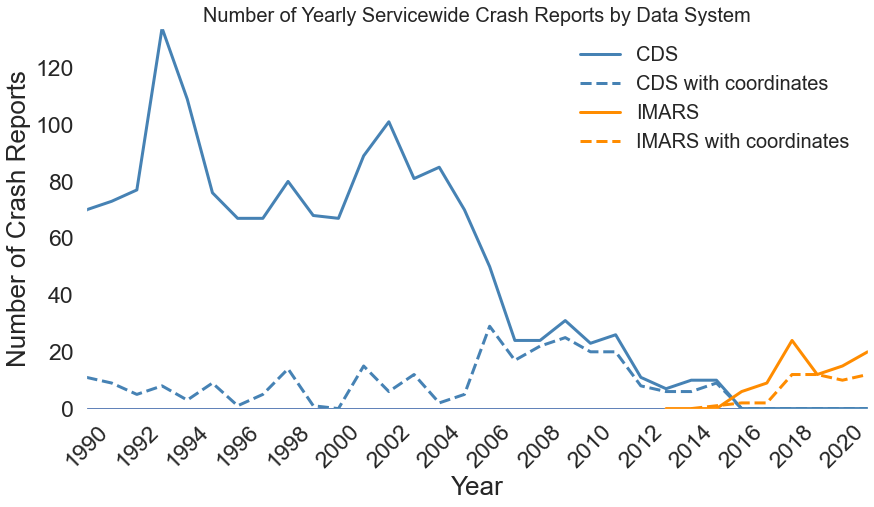

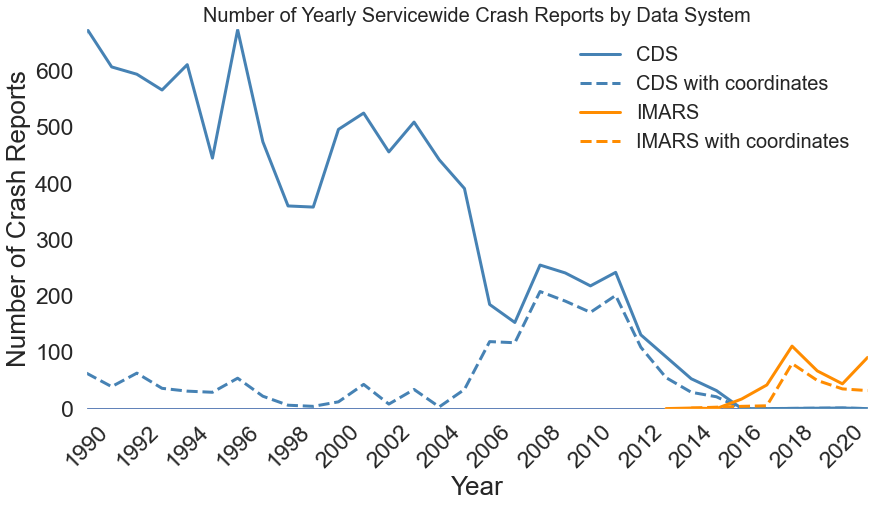

In [33]:
make_yearly_crash_fig("NCR")

## Regional Trends

### Injury & Fatality at all Parks

In [34]:
def create_park_table(region):
    #create dataframe to have number of crashes for each region
    
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    df = df.groupby("Park").agg({
            "Num_Fatalities":sum,
            'Num_Injuries':sum, 
            'No Injury':sum, 
            'Possible Injury':sum,
            'Non-incapacitating Injury':sum, 
            'Incapacitating Injury':sum, 
            'Fatality':sum,
            'Unknown Injury':sum, 
            'Num_Fatalities':sum, 
            'Num_Injuries':sum, 
            'Injury or Fatal':sum,
            'INCID_NO':'count'
        }).reset_index()
    
    df['Number of Crashes'] = df['INCID_NO']
    df['Number of Fatalities'] = df['Num_Fatalities']
    df['Number of Injuries'] = df['Num_Injuries'] #check if injuries means serious injuries
    
    df_final = df[['Park','Number of Fatalities','Number of Injuries','Number of Crashes']].sort_values("Number of Fatalities", ascending = False)
    
    return df_final


In [35]:
def make_table(region):
    df = create_park_table(region)
    doc_name = './22-23\Drafted Deliverables\Figures/Park level tables/' + region + ".docx"
    doc = docx.Document(doc_name)
    doc.add_heading("Injury & fatality, at All Region Park Units")
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])

    doc.save(doc_name)

### Crashes by posted speed

In [36]:
def create_speed_table(region = 1, crash_group=1, injury_type=1, injury_type2 = 1):
    #create dataframe to have number of crashes by crash groups (e.g. animals involved, VRUs, etc.)
    #can also add in filters for different injury severity. These can be combined as well. 
    
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    
    if crash_group != 1:
        df = df.loc[df[crash_group]==1]
    else: 
        df = df
        
        
    if injury_type !=1:
        if injury_type2 != 1:
            df = df.loc[(df[injury_type]>0)|(df[injury_type2]>0)]
        else:
            df = df.loc[df[injury_type]>0]
    
    speed_list = []
    
    for x in ['5_mph', '10_mph', '15_mph', '20_mph', '25_mph',
       '30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph',
       '65_mph', '70_mph', '75_mph']:
        speed_list.append(df[x].sum())
        
    
    
    df_final = pd.DataFrame({'Posted Speed':[5,10,15,20,25,30,35,40,45,50,55, 60, 65, 70, 75], 
                               'Total Crashes':speed_list})
    
    return df_final


In [37]:
def create_posted_speed_fig(region):
    
    df_by_speed = create_speed_table(region)
    df_by_speed_fatals = create_speed_table(region, 1, 'Fatality')
    df_by_speed_serious_injury = create_speed_table(region,1, 'Incapacitating Injury')


    #graph_title = "No Commercial Vehicle Sign Locations by Physical Locations on BLRI Parkway"
    axis_title = "Number of Crashes Involving VRUs"
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    tick_spacing = 5


    ax[0].bar(df_by_speed_fatals['Posted Speed'],
            df_by_speed_fatals['Total Crashes'],
            width = 5, color = 'lightsteelblue', edgecolor = "black", linewidth=2)

    ax[1].bar(df_by_speed_serious_injury['Posted Speed'],
            df_by_speed_serious_injury['Total Crashes'],
            width = 5, hatch = "/", color = 'lightsteelblue', edgecolor = "black", linewidth=2)

    ax[2].bar(df_by_speed['Posted Speed'],
            df_by_speed['Total Crashes'],
            width = 5, color = 'lightsteelblue', edgecolor = "black", linewidth=2)


    #bar_max = 1.15*max(max(VRU_by_speed['Total Crashes']), max(Animals_by_speed['Total Crashes']))

    #ax.set_ylim([0, bar_max])
    #ax.set_xlim([0, 58])
    ax[0].set_title("Fatal crashes",fontsize= 24, pad = 20) # title of plot
    ax[1].set_title("Serious injury crashes",fontsize= 24, pad = 20) # title of plot
    ax[2].set_title("All Crashes",fontsize= 24, pad = 20) # title of plot

    # Make some labels.
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=20
        )

    # Make some labels.
    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=20
        )

        # Make some labels.
    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(
            rect.get_x() + rect.get_width() / 2, height + 0.5, label, ha="center", va="bottom",fontsize=20
        )


    #ax[0].set_ylim([0, bar_max])
    ax[0].set_xlim([0, 78])
    ax[0].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #ax[0].set_ylabel("Number of Crashes", fontsize = 30)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_xlim([0, 78])
    ax[1].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].set_ylabel("Number of Crashes", fontsize = 30)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_xlim([0, 78])
    ax[2].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].set_xlabel('Posted Speed',fontsize = 30) #xlabel
    #ax[2].set_ylabel("Number of Crashes", fontsize = 30)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)


    #plt.title(graph_title,fontsize=34)
    # set the spacing between subplots
    plt.subplots_adjust(
                        bottom=0.065, 
                        top=0.95, 
                        wspace=0.4, 
                        hspace=0.6)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Posted Speed Figures/' + region + ".png"
    
    plt.savefig(doc_name)


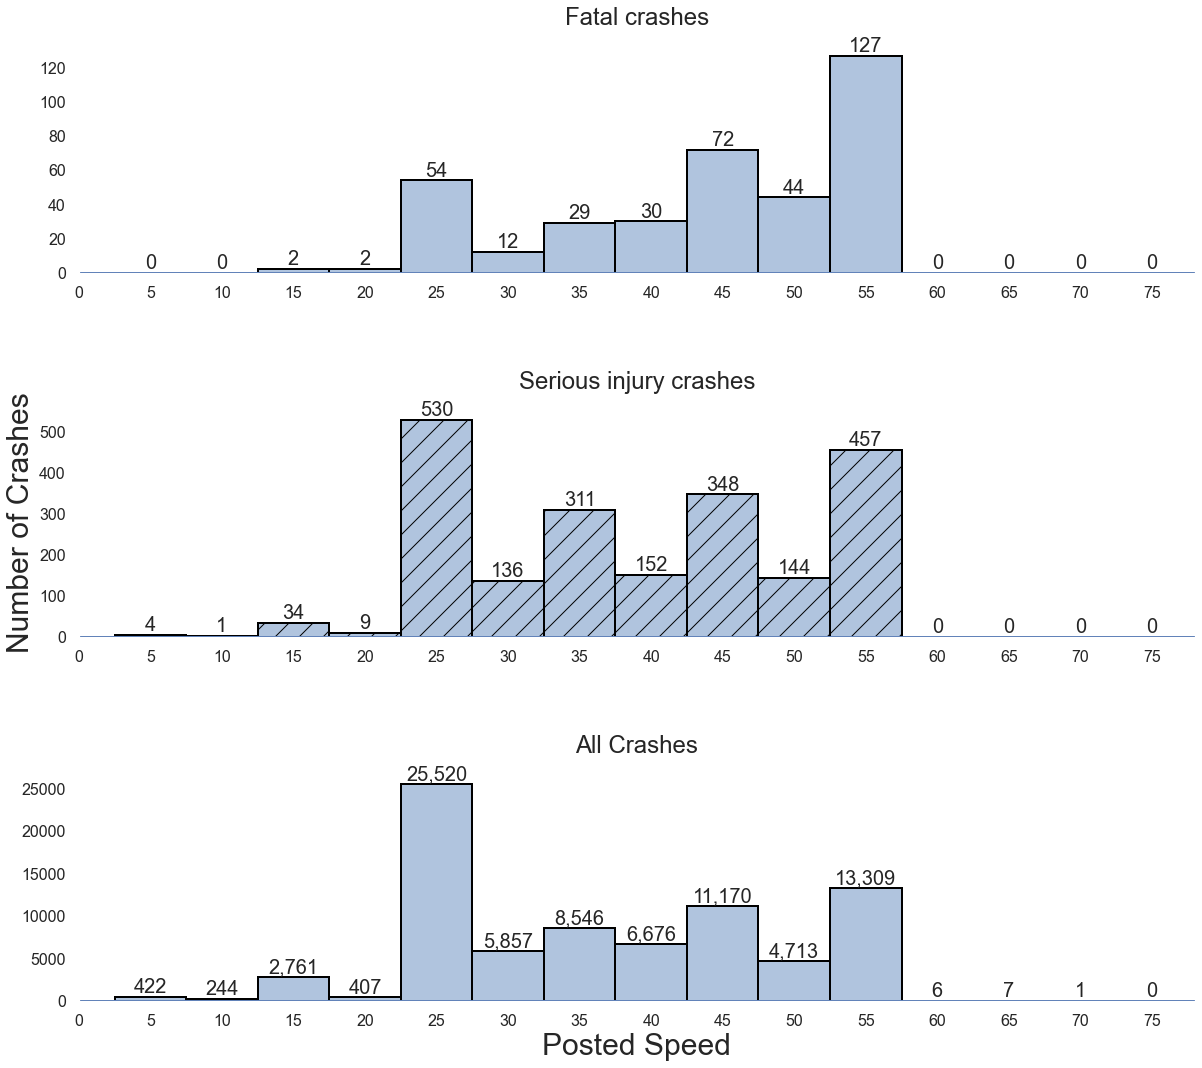

In [38]:
create_posted_speed_fig("NCR")

### Wildlife crashes

In [39]:
print(round(len(analysis_2022.loc[analysis_2022['Involving Animal']==1])/len(analysis_2022)*100,2), "% of total crashes involve Animals")


animal_serious_injury = sum(analysis_2022.loc[(analysis_2022['Incapacitating Injury']==1)&(analysis_2022['Involving Animal']==1)]['Num_Injuries'])
animal_injury = sum(analysis_2022.loc[(analysis_2022['Injury or Fatal']==1)&(analysis_2022['Involving Animal']==1)]['Num_Injuries'])
animal_fatals = sum(analysis_2022.loc[(analysis_2022['Fatality']==1)&(analysis_2022['Involving Animal']==1)]['Num_Fatalities'])

print(int(animal_injury+animal_fatals), "injuries or fatalities")
print(int(animal_serious_injury), "serious injuries")
print(int(animal_fatals), "fatalities")


11.03 % of total crashes involve Animals
2806 injuries or fatalities
295 serious injuries
26 fatalities


In [40]:
def create_wildlife_crashes_table(region):
    percent_animal = round(len(analysis_2022.loc[analysis_2022['Involving Animal']==1])/len(analysis_2022)*100,2)
    animal_serious_injury = sum(analysis_2022.loc[(analysis_2022['Incapacitating Injury']==1)&(analysis_2022['Involving Animal']==1)]['Num_Injuries'])
    animal_injury = sum(analysis_2022.loc[(analysis_2022['Injury or Fatal']==1)&(analysis_2022['Involving Animal']==1)]['Num_Injuries'])
    animal_fatals = sum(analysis_2022.loc[(analysis_2022['Fatality']==1)&(analysis_2022['Involving Animal']==1)]['Num_Fatalities'])


    df = analysis_2022.loc[analysis_2022['RGN']==region]
    percent_animal_region = round(len(df.loc[df['Involving Animal']==1])/len(df)*100,2)
    animal_serious_injury_region = sum(df.loc[(df['Incapacitating Injury']==1)&(df['Involving Animal']==1)]['Num_Injuries'])
    animal_injury_region = sum(df.loc[(df['Injury or Fatal']==1)&(df['Involving Animal']==1)]['Num_Injuries'])
    animal_fatals_region = sum(df.loc[(df['Fatality']==1)&(df['Involving Animal']==1)]['Num_Fatalities'])
    
    df_final = pd.DataFrame({
        "Fields": ["% of Total Crashes", "Number of Total Injuries", "Number of Serious Injuries", "Number of Fatalities"],
        "Region": [str(percent_animal_region) + "%", str(int(animal_injury_region)), int(animal_serious_injury_region), int(animal_fatals_region)], 
        "National": [str(percent_animal) + "%", str(int(animal_injury)), int(animal_serious_injury), int(animal_fatals)]
    })
    
    return df_final

In [41]:
def create_posted_speed_fig_animals(region):
    Animals_by_speed = create_speed_table(region, 'Involving Animal')
    Animals_by_speed_fatals = create_speed_table(region, 'Involving Animal', 'Fatality')
    Animals_by_speed_serious_injury = create_speed_table(region, 'Involving Animal', 'Incapacitating Injury')

    #graph_title = "No Commercial Vehicle Sign Locations by Physical Locations on BLRI Parkway"
    axis_title = "Number of Crashes Involving VRUs"
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    tick_spacing = 5


    ax[0].bar(Animals_by_speed_fatals['Posted Speed'],
            Animals_by_speed_fatals['Total Crashes'],
            width = 5, color = 'tan', edgecolor = "black", linewidth=2)

    ax[1].bar(Animals_by_speed_serious_injury['Posted Speed'],
            Animals_by_speed_serious_injury['Total Crashes'],
            width = 5, hatch = "/", color = 'tan', edgecolor = "black", linewidth=2)

    ax[2].bar(Animals_by_speed['Posted Speed'],
            Animals_by_speed['Total Crashes'],
            width = 5, color = 'tan', edgecolor = "black", linewidth=2)


    #bar_max = 1.15*max(max(VRU_by_speed['Total Crashes']), max(Animals_by_speed['Total Crashes']))

    #ax.set_ylim([0, bar_max])
    #ax.set_xlim([0, 58])
    ax[0].set_title("Fatal crashes",fontsize= 24, pad = 20) # title of plot
    ax[1].set_title("Serious injury crashes",fontsize= 24, pad = 20) # title of plot
    ax[2].set_title("All Crashes",fontsize= 24, pad = 20) # title of plot

    # Make some labels.
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=20
        )

    # Make some labels.
    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=20
        )

        # Make some labels.
    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=20
        )


    #ax[0].set_ylim([0, bar_max])
    ax[0].set_xlim([0, 78])
    ax[0].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #ax[0].set_ylabel("Number of Crashes", fontsize = 30)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_xlim([0, 78])
    ax[1].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].set_ylabel("Number of Crashes Involving Animals", fontsize = 30)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_xlim([0, 78])
    ax[2].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].set_xlabel('Posted Speed',fontsize = 30) #xlabel
    #ax[2].set_ylabel("Number of Crashes", fontsize = 30)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)



    #plt.title(graph_title,fontsize=34)
    # set the spacing between subplots
    plt.subplots_adjust(
                        bottom=0.1, 

                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    doc_name = './22-23\Drafted Deliverables\Figures/Wildlife Figures/' + region + ".png"
    
    plt.savefig(doc_name)


In [42]:
def create_wildlife_crashes_table_park(region):
    df = analysis_2022.loc[analysis_2022['Involving Animal']==1]
    df = df.loc[df['RGN']==region]
    df = df.groupby('Park').sum().reset_index()
    df_final  = df[['Park','ones','Num_Fatalities','Num_Injuries']].sort_values(by = ['ones'], ascending = False).rename(columns = {
        "ones":"Number of Crash Reports",
        "Num_Fatalities": "Number of Fatalities",
        "Num_Injuries": "Number of Injuries"
    }).astype({"Number of Fatalities":"int",
              "Number of Injuries":"int"})    
    return df_final

In [43]:
def create_wildlife_crashes_table_alltypes(region):
    df = analysis_2022.loc[analysis_2022['Involving Animal']==1]
    df = df.loc[df['RGN']==region]
    
    df_final = pd.DataFrame(columns = [
    "Animal",
    "Number of Fatalities",
    "Number of Serious Injuries",
    "Number of Total Injuries"
])
    
    animal_list = ['HorseLlama', 'Cow',
       'Deer', 'Elk', 'Moose', 'Buffalo', 'Bear', 'Antelope', 'SheepGoats',
       'OtherWild', 'OtherDomestic']
    
    for x in animal_list: 
        animal_serious_injury = sum(analysis_2022.loc[(analysis_2022['Incapacitating Injury']==1)&(analysis_2022[x]==1)]['Num_Injuries'])
        animal_injury = sum(analysis_2022.loc[(analysis_2022['Injury or Fatal']==1)&(analysis_2022[x]==1)]['Num_Injuries'])
        animal_fatals = sum(analysis_2022.loc[(analysis_2022['Fatality']==1)&(analysis_2022[x]==1)]['Num_Fatalities'])
        
        df_final = df_final.append({
            "Animal": x, 
            "Number of Fatalities": animal_fatals, 
            "Number of Serious Injuries": animal_injury, 
            "Number of Total Injuries": animal_serious_injury}, ignore_index=True)

    df_final = df_final.sort_values(by = ['Number of Fatalities'], ascending = False).astype({
            "Number of Fatalities":"int",
              "Number of Serious Injuries":"int",
              "Number of Total Injuries":"int"})    
    return df_final

# Create final document

In [44]:
doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - Testing.docx'
doc = docx.Document(doc_name)
styles = doc.styles
for s in styles:
    print(s)
print(styles)

_ParagraphStyle('Normal') id: 2437071402752
_ParagraphStyle('Heading 1') id: 2437048664320
_ParagraphStyle('Heading 2') id: 2437048667728
_ParagraphStyle('Heading 3') id: 2437048665520
_ParagraphStyle('Heading 6') id: 2437048666528
_ParagraphStyle('Heading 7') id: 2437048668016
_ParagraphStyle('Heading 8') id: 2437048665328
_ParagraphStyle('Heading 9') id: 2437086228048
_TableStyle('Normal Table') id: 2437086226272
_ParagraphStyle('toc 1') id: 2437113198480
_ParagraphStyle('toc 2') id: 2437113197712
_ParagraphStyle('toc 3') id: 2437113197808
_ParagraphStyle('Header') id: 2437074844400
_ParagraphStyle('Footer') id: 2437105912464
_TableStyle('Table Grid1') id: 2437109304672
_TableStyle('Table Grid') id: 2437109302416
_ParagraphStyle('List Paragraph') id: 2437109305200
_ParagraphStyle('annotation text') id: 2437077504112
_ParagraphStyle('annotation subject') id: 2437077506032
_ParagraphStyle('footnote text') id: 2437081939824
_ParagraphStyle('Normal (Web)') id: 2437077504208
_TableStyle('

In [45]:
doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - Testing.docx'
doc = docx.Document(doc_name)
styles = doc.styles
table_styles = [
    s for s in styles if s.type == WD_STYLE_TYPE.TABLE
]
for style in table_styles:
    print(style.name)


NameError: name 'WD_STYLE_TYPE' is not defined

In [ ]:
def add_regional_information(region):
    df = make_source_table(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - Testing.docx'
    doc = docx.Document(doc_name)
    doc.add_heading("Overview of Region")
    doc.add_heading("Available Data", 2)
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 1. Overview of Data Sources", style="Caption")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    doc.add_heading("Data Quality", 2)
    doc.add_heading("Completeness of crash reports by field", 3)

    doc.add_paragraph("Below is a table of CDS and IMARS crash report completeness, broken down by region. Reports are labeled as incomplete if they only contain a crash table with core crash elements (e.g. coordinates, crash classification, etc.). For CDS crashes, this means vehicle and passenger data tables are not populated. The NCR was an outlier as compared to other regions, with around 8% of reports failing to include vehicle or passenger data tables. For IMARS crashes, this means crash details, vehicle, and passenger data tables are not populated. IMARS reports have generally been less complete across each region. ")
    doc.add_paragraph("Table 2. Regional CDS Crash Reports", style="Caption")
    
    df = make_data_quality_table_cds(region)
    
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 3. Regional IMARS Crash Reports", style="Caption")
    
    df = make_data_quality_table_imars(region)
    
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
            
            
    doc.add_paragraph(" ")

    doc.add_heading("Completeness of crash report by year", 3)
    doc.add_paragraph(" ")
    make_yearly_crash_fig(region)
    doc.add_paragraph("Figure 1. Yearly count of serious injuries by database, 1989-2021", style="Caption")
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Yearly fatality/' + region + ".png", width = 5943600, height = 3447288)
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 2. Yearly count of fatalities by database, 1989-2021", style="Caption")
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Yearly fatality/' + region + ".png", width = 5943600, height = 3447288)
    doc.add_paragraph(" ")

    doc.add_heading("Completeness of crash report by park", 3)
    doc.add_paragraph(" ")
    doc.add_paragraph("Add figure showing trends over time across CDS and IMARS. Repeat for all crashes, crashes with injuries, and crashes with fatalities")
    doc.add_paragraph(" ")

    doc.add_heading("Regional Trends", 2)
    doc.add_heading("Park-level crashes", 3)

    doc.add_paragraph(" ")
    doc.add_paragraph("Table 4. Injury & fatality, at All Region Park Units", style="Caption")

    df = create_park_table(region)

    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    doc.add_paragraph(" ")
    doc.add_heading("Crashes by posted speed", 3)
    doc.add_paragraph("Figure 3. Crashes by Posted Speed (1990-2021, data from STARS, CDS, IMARS)", style="Caption")

    create_posted_speed_fig(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Posted Speed Figures/' + region + ".png", width = 5943600, height = 4828270)
    
    
    doc.add_heading("Crashes involving animals", 3)
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 5. Regional Wildlife Crashes (1990-2021, data from STARS, CDS, IMARS) ", style="Caption")
    df = create_wildlife_crashes_table(region)
    

    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    doc.add_paragraph(" ")
    
    doc.add_paragraph("Figure 4. Crashes by Posted Speed Involving Animals (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_posted_speed_fig_animals(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Wildlife Figures/' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 6. Number of crashes involving animals by park", style="Caption")
    
    df = create_wildlife_crashes_table_park(region)
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])

    doc.add_paragraph("Table 7. Number of crashes involving animals by type of animal", style="Caption")
    
    df = create_wildlife_crashes_table_alltypes(region)
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    doc.add_paragraph(" ")
    

    doc.add_heading("Wish List Items")
    doc.add_paragraph("Section to be completed for final briefing")

    doc_name_new = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - ' + region + ".docx"

    doc.save(doc_name_new)

In [ ]:
add_regional_information("NCR")

In [ ]:
for x in analysis_2022.RGN.unique():
    print(x)
    add_regional_information(x)

In [ ]:

for x in analysis_2022.RGN.unique():
    print(x)
